In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from itertools import cycle
from sklearn import ensemble
import time
from sklearn.metrics import recall_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from scipy import interp
import statsmodels.api as sm
from sklearn.metrics import recall_score

from sklearn.model_selection import ShuffleSplit
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [17]:
df_cardio = pd.read_csv('Cardiotocography.csv', sep=',')

df_cardio.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [18]:
null_data = df_cardio[df_cardio.isnull().any(axis=1)]
null_data

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
2126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2127,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,NaN,NaN,0.481,0.015,0.015,0.001,0.005,87.0,7.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
df_cardio = df_cardio.dropna()

In [20]:
df_cardio = df_cardio.drop(['Min','Mean','Mode'], axis=1)

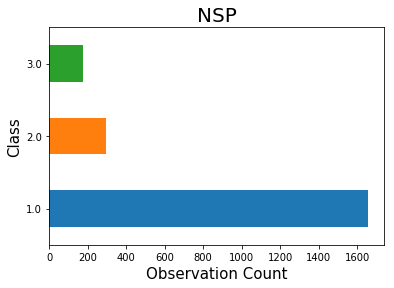

In [21]:
df_cardio['NSP'].value_counts()[:].plot(kind='barh')
plt.title('NSP',fontsize=20)
plt.xlabel('Observation Count',fontsize=15)
plt.ylabel('Class',fontsize=15)
plt.savefig('target__distribution.png')

## Train-Test Split

In [44]:
y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 

## Train-Validation Split

In [45]:
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 


## Baseline GBRF Model

In [46]:
start_time = time.time()

params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

y_pred_clf = clf.predict(X_test)
print('Accuracy of gradient boost classifier on test set: {:.3f}\n'.format(clf.score(X_train_sub, y_train_sub)))

print('Cross validation score: {}\n'.format(cross_val_score(clf, X_test_sub, y_test_sub, cv=10).mean()))

print('Recall score: {}\n'.format(recall_score(y_test, y_pred_clf, average = 'micro')))

print("--- %s seconds ---" % (time.time() - start_time))

Accuracy of gradient boost classifier on test set: 0.999

Cross validation score: 0.9115304303539598

Recall score: 0.9647887323943662

--- 14.724570035934448 seconds ---


In [47]:
print(np.unique(y_pred_clf))

[1. 2. 3.]


In [48]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

classifier = OneVsRestClassifier(ensemble.GradientBoostingClassifier(**params))
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))

Average AUC score: 0.9845810000634594


## Feature Selection

### f_classif

In [33]:
from sklearn.feature_selection import SelectKBest, f_classif

y = df_cardio['NSP']
X = df_cardio.drop('NSP',axis=1)

In [12]:
def get_selectKbest_scores(feature_amount):
    score = []
    y = df_cardio['NSP']
    X = df_cardio.drop('NSP',axis=1)
    
    for i in range(1,feature_amount+1):
        
        selector = SelectKBest(f_classif, k = i)

        selector.fit(X, y)

        X_new = selector.transform(X)

        y_new = df_cardio['NSP']

        X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size = 0.2, random_state = 465) 
                   
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, 
                                                                            random_state = 465) 
                   
        params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

        # Initialize and fit the model.
        clf = ensemble.GradientBoostingClassifier(**params)
        clf.fit(X_train_sub, y_train_sub)
        
        score.append(cross_val_score(clf, X_test, y_test, cv=20).mean())
        
    #return score
    plt.figure(figsize=(12, 6)) #visualize mean prediction errors in relation to k number
    plt.plot(range(1,feature_amount+1), score, color='blue', linestyle='dashed', marker='o',  
    markerfacecolor='blue', markersize=10)    
    plt.title('Score vs Best Feature Count')  
    plt.xlabel('Feature Count')  
    plt.ylabel('Score')

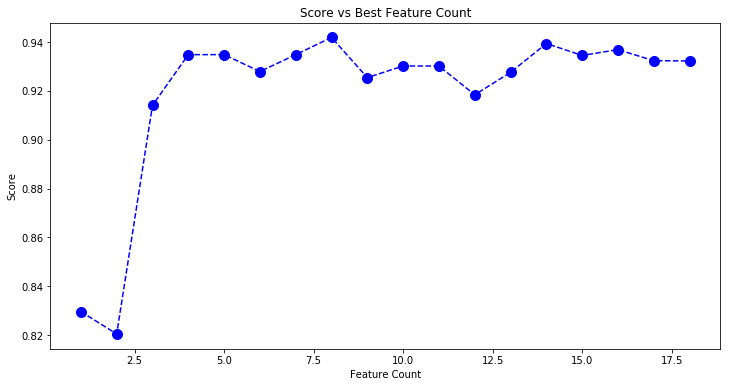

In [13]:
get_selectKbest_scores(18)

In [36]:
selector = SelectKBest(f_classif, k=8)

selector.fit(X, y)

X_new = selector.transform(X)

X_new.shape
print("feature indices: {}\n".format(selector.get_support(indices=True)))

y = df_cardio['NSP']

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
                   
params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train_sub, y_train_sub)

y_pred_clf = clf.predict(X_test_sub)
print('Accuracy of gradient boost classifier on test set: {:.3f}\n'.format(clf.score(X_test, y_test)))

fpr, tpr, thresholds = roc_curve(y_test_sub, y_pred_clf, pos_label=2)
print('AUC score: {}\n'.format(auc(fpr, tpr)))

print('Recall score: {}\n'.format(recall_score(y_test_sub, y_pred_clf, average = 'micro')))


print(cross_val_score(clf, X_test, y_test, cv=20).mean())

feature indices: [ 0  1  6  7  8  9 15 16]

Accuracy of gradient boost classifier on test set: 0.951

AUC score: 0.8298950014788524

Recall score: 0.95

0.9418831168831169


In [49]:
y = df_cardio['NSP']
X = df_cardio[['LB','AC','DP','ASTV','MSTV','ALTV','Median','Variance']]
                   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
  

In [50]:
params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train_sub, y_train_sub)

y_pred_clf = clf.predict(X_test_sub)
print('Accuracy of gradient boost classifier on test set: {:.3f}\n'.format(clf.score(X_train_sub, y_train_sub)))

print('Recall score: {}\n'.format(recall_score(y_test_sub, y_pred_clf, average = 'micro')))

print(cross_val_score(clf, X_test_sub, y_test_sub, cv=20).mean())

Accuracy of gradient boost classifier on test set: 0.999

Recall score: 0.95

0.9169278895768833


In [51]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

classifier = OneVsRestClassifier(ensemble.GradientBoostingClassifier(**params))
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))

Average AUC score: 0.9802663858382007


## Feature Selection with Recursive Feature Elimination

In [123]:
# Feature Extraction with RFE
from sklearn.feature_selection import RFE

array = df_cardio.values
X = array[:,0:18]
Y = array[:,18]
# feature extraction

params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
rfe = RFE(clf, 16)
fit = rfe.fit(X, Y)
print("Num Features: {}".format(fit.n_features_+1))
print("Selected Features: {}".format(fit.support_))
print("Feature Ranking: {}".format(fit.ranking_))

Num Features: 17
Selected Features: [ True  True  True  True  True False  True  True  True  True  True  True
  True  True False  True  True  True]
Feature Ranking: [1 1 1 1 1 3 1 1 1 1 1 1 1 1 2 1 1 1]


In [121]:
y = df_cardio['NSP']
X = df_cardio.drop(['NSP','DS'],axis=1)
                   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
  

In [122]:
params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train_sub, y_train_sub)

y_pred_clf = clf.predict(X_test_sub)
print('Accuracy of gradient boost classifier on test set: {:.3f}\n'.format(clf.score(X_train_sub, y_train_sub)))

print(cross_val_score(clf, X_test_sub, y_test_sub, cv=10).mean())

Accuracy of gradient boost classifier on test set: 0.999

0.9085001273236566


In [39]:
y = df_cardio['NSP']
X = df_cardio.drop(['NSP','DS','Nzeros'],axis=1)
                   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
  

In [40]:
params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train_sub, y_train_sub)

y_pred_clf = clf.predict(X_test_sub)
print('Accuracy of gradient boost classifier on test set: {:.3f}\n'.format(clf.score(X_train_sub, y_train_sub)))

print('Recall score: {}\n'.format(recall_score(y_test_sub, y_pred_clf, average = 'micro')))

print(cross_val_score(clf, X_test_sub, y_test_sub, cv=10).mean())

Accuracy of gradient boost classifier on test set: 0.999

AUC score: 0.8356994971901804

Recall score: 0.9529411764705882

0.9055589508530684


In [43]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

classifier = OneVsRestClassifier(ensemble.GradientBoostingClassifier(**params))
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))

Average AUC score: 0.9862838440356273


## Feature Selection based on Importance

### Measure: Importance Score

In [159]:
params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

# Initialize and fit the model.
forest = ensemble.GradientBoostingClassifier(**params)
forest.fit(X_train_sub, y_train_sub)

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train_sub.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 7 (0.213688)
2. feature 6 (0.146642)
3. feature 8 (0.140586)
4. feature 13 (0.115770)
5. feature 5 (0.110974)
6. feature 1 (0.047933)
7. feature 0 (0.039282)
8. feature 3 (0.039090)
9. feature 12 (0.032703)
10. feature 9 (0.032216)
11. feature 10 (0.029334)
12. feature 14 (0.019953)
13. feature 11 (0.018414)
14. feature 2 (0.009069)
15. feature 4 (0.002501)
16. feature 15 (0.001844)


IndexError: index 16 is out of bounds for axis 0 with size 16

In [41]:
y = df_cardio['NSP']
X = df_cardio.drop(['NSP','Tendency'],axis=1)
                   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
 

In [42]:
params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train_sub, y_train_sub)

y_pred_clf = clf.predict(X_test_sub)
print('Accuracy of gradient boost classifier on test set: {:.3f}\n'.format(clf.score(X_train_sub, y_train_sub)))

fpr, tpr, thresholds = roc_curve(y_test_sub, y_pred_clf, pos_label=2)
print('AUC score: {}\n'.format(auc(fpr, tpr)))

print('Recall score: {}\n'.format(recall_score(y_test_sub, y_pred_clf, average = 'micro')))

print(cross_val_score(clf, X_test_sub, y_test_sub, cv=10).mean())

Accuracy of gradient boost classifier on test set: 0.999

AUC score: 0.830930198166223

Recall score: 0.9470588235294117

0.9055589508530684


### Measure: F-score

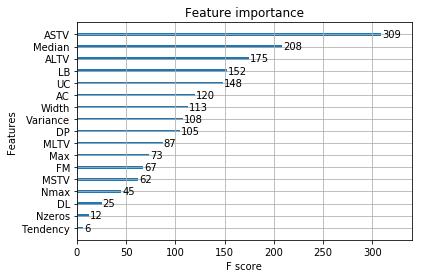

In [169]:
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance

# fit model no training data
model = XGBClassifier()
model.fit(X_train_sub, y_train_sub)
# plot feature importance
plot_importance(model)
plt.savefig('Feature_importance.png')
pyplot.show()

In [52]:
y = df_cardio['NSP']
X = df_cardio.drop(['NSP','Tendency','Nzeros','DL','Nmax','DS'],axis=1)
                   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
 

In [53]:
params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train_sub, y_train_sub)

y_pred_clf = clf.predict(X_test_sub)
print('Accuracy of gradient boost classifier on test set: {:.3f}\n'.format(clf.score(X_train_sub, y_train_sub)))

print('Recall score: {}\n'.format(recall_score(y_test_sub, y_pred_clf, average = 'micro')))

print(cross_val_score(clf, X_test_sub, y_test_sub, cv=10).mean())

Accuracy of gradient boost classifier on test set: 0.999

Recall score: 0.9529411764705882

0.9117035905271198


In [54]:
# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

params = {'n_estimators': 500,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .1}

classifier = OneVsRestClassifier(ensemble.GradientBoostingClassifier(**params))
y_score = classifier.fit(X_train_sub, y_train_sub).decision_function(X_test_sub)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_sub[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

print('Average AUC score: {}'.format((roc_auc[0]+roc_auc[1]+roc_auc[2])/3))

Average AUC score: 0.9800611313451472


## Changing the Tree Depth

In [229]:
def get_gradtree(num_estimators,num_depth,num_rate):
    params = {'n_estimators': num_estimators,
          'max_depth': num_depth,
          'learning_rate': num_rate,    
          'loss': 'deviance'}

    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train_sub, y_train_sub)

    y_pred_clf = clf.predict(X_test_sub)
    print('Accuracy of GBRF classifier on test set: {:.2f}\n'.format(clf.score(X_test_sub, y_test_sub)))

    print('Cross_validation score of GBRF: {}\n'.format(cross_val_score(clf, X_test_sub, y_test_sub, cv=10).mean()))

In [236]:
y = df_cardio['NSP']
X = df_cardio.drop(['NSP','Tendency','Nzeros','DL','Nmax','DS'],axis=1)
                   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
 

In [237]:
get_gradtree(500,2,.1)


Accuracy of GBRF classifier on test set: 0.97

Cross_validation score of GBRF: 0.9120550038197097



In [231]:
get_gradtree(500,4,.1)


Accuracy of GBRF classifier on test set: 0.95

Cross_validation score of GBRF: 0.9151642475171886



In [238]:
get_gradtree(500,6,.1)


Accuracy of GBRF classifier on test set: 0.96

Cross_validation score of GBRF: 0.9234733893557422



In [239]:
get_gradtree(500,8,.1)


Accuracy of GBRF classifier on test set: 0.95

Cross_validation score of GBRF: 0.8997606315253373



## Change Number of Estimators

In [240]:
y = df_cardio['NSP']
X = df_cardio.drop(['NSP','Tendency','Nzeros','DL','Nmax','DS'],axis=1)
                   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
 

In [241]:
get_gradtree(250,6,.1)

Accuracy of GBRF classifier on test set: 0.95

Cross_validation score of GBRF: 0.9175910364145657



In [242]:
get_gradtree(1000,6,.1)

Accuracy of GBRF classifier on test set: 0.95

Cross_validation score of GBRF: 0.9205322128851542



In [243]:
get_gradtree(1500,6,.1)

Accuracy of GBRF classifier on test set: 0.95

Cross_validation score of GBRF: 0.9175910364145657



In [245]:
get_gradtree(2000,6,.1)

Accuracy of GBRF classifier on test set: 0.96

Cross_validation score of GBRF: 0.9204481792717086



In [246]:
get_gradtree(2500,6,.1)

Accuracy of GBRF classifier on test set: 0.95

Cross_validation score of GBRF: 0.9145607333842627



## Change Learning Rate

In [247]:
y = df_cardio['NSP']
X = df_cardio.drop(['NSP','Tendency','Nzeros','DL','Nmax','DS'],axis=1)
                   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
 

In [248]:
get_gradtree(1000,6,.001)

Accuracy of GBRF classifier on test set: 0.94

Cross_validation score of GBRF: 0.9027960275019098



In [249]:
get_gradtree(1000,6,.01)

Accuracy of GBRF classifier on test set: 0.96

Cross_validation score of GBRF: 0.914733893557423



In [250]:
get_gradtree(1000,6,.1)

Accuracy of GBRF classifier on test set: 0.96

Cross_validation score of GBRF: 0.9146498599439775



In [256]:
get_gradtree(1000,6,.2)

Accuracy of GBRF classifier on test set: 0.95

Cross_validation score of GBRF: 0.9235625159154571



In [255]:
get_gradtree(1000,6,.3)

Accuracy of GBRF classifier on test set: 0.95

Cross_validation score of GBRF: 0.914644766997708



# Final Gradient Tree Model

In [61]:
y = df_cardio['NSP']

X = df_cardio.drop(['NSP','Tendency','Nzeros','Nmax','DS','DL'],axis=1) #drop least important F-score features

#X = df_cardio[['LB','AC','DP','ASTV','MSTV','ALTV','Median','Variance']] #selectKbest

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
 
start_time = time.time()
    
params = {'n_estimators': 1000,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .2}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train_clf = clf.predict(X_train)
predict_test_clf = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train_clf, margins=True)
table_test = pd.crosstab(y_test, predict_test_clf, margins=True)

y_pred_clf = clf.predict(X_test)
print('Accuracy of gradient boosted random forest on test set: {:.4f}\n'.format(clf.score(X_test, y_test)))

print('Cross validation score: {:.4f}\n'.format(cross_val_score(clf, X_test, y_test, cv=20).mean()))

print('Recall score: {}\n'.format(recall_score(y_test, y_pred_clf, average = 'micro')))

print("--- %s seconds ---" % (time.time() - start_time))


Accuracy of gradient boosted random forest on test set: 0.9648

Cross validation score: 0.9301

Recall score: 0.9647887323943662

--- 35.93630409240723 seconds ---


In [20]:
print(np.unique(y_pred_clf))

[1. 2. 3.]


In [21]:
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

         1.0       0.97      1.00      0.98       339
         2.0       0.93      0.83      0.88        48
         3.0       0.97      0.85      0.90        39

    accuracy                           0.96       426
   macro avg       0.96      0.89      0.92       426
weighted avg       0.96      0.96      0.96       426



- The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.
- The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.
- The F-beta score weights the recall more than the precision by a factor of beta. beta = 1.0 means recall and precision are equally important.
- The support is the number of occurrences of each class in y_test.

In [22]:
# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train_clf, margins=True)
table_test = pd.crosstab(y_test, predict_test_clf, margins=True)

train_tI_errors = ((1-(table_train.loc[1.0,1.0]/table_train.loc['All',1.0]))
                   +(1-(table_train.loc[2.0,2.0]/table_train.loc['All',2.0]))
                   +(1-(table_train.loc[3.0,3.0]/table_train.loc['All',3.0])))/3 

train_tII_errors = ((1-(table_train.loc[1.0,1.0]/table_train.loc[1.0,'All']))
                   +(1-(table_train.loc[2.0,2.0]/table_train.loc[2.0,'All']))
                   +(1-(table_train.loc[3.0,3.0]/table_train.loc[3.0,'All'])))/3 

test_tI_errors = ((1-(table_test.loc[1.0,1.0]/table_test.loc['All',1.0]))
                   +(1-(table_test.loc[2.0,2.0]/table_test.loc['All',2.0]))
                   +(1-(table_test.loc[3.0,3.0]/table_test.loc['All',3.0])))/3 

test_tII_errors = ((1-(table_test.loc[1.0,1.0]/table_test.loc[1.0,'All']))
                   +(1-(table_test.loc[2.0,2.0]/table_test.loc[2.0,'All']))
                   +(1-(table_test.loc[3.0,3.0]/table_test.loc[3.0,'All'])))/3 
print((
    'Training set accuracy:\n'
    'AVG Percent Type I errors: {}\n'
    'AVG Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'AVG Percent Type I errors: {}\n'
    'AVG Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
AVG Percent Type I errors: 0.0016028204718014545
AVG Percent Type II errors: 0.0016028204718014545

Test set accuracy:
AVG Percent Type I errors: 0.04356594373606045
AVG Percent Type II errors: 0.10782089100673171


In [23]:
print((
    'Accuracy Differentials:\n'
    'Type I error difference: {}\n\n'
    'Type II error difference: {}\n'
).format(test_tI_errors - train_tI_errors, test_tII_errors - train_tII_errors))

Accuracy Differentials:
Type I error difference: 0.041963123264258995

Type II error difference: 0.10621807053493026



## ROC Curve

In [62]:
y = df_cardio['NSP']

X = df_cardio.drop(['NSP','Tendency','Nzeros','Nmax','DS','DL'],axis=1) #drop least important F-score features

#X = df_cardio[['LB','AC','DP','ASTV','MSTV','ALTV','Median','Variance']] #selectKbest

#X = df_cardio.drop(['NSP','DS','Nzeros'],axis=1) #Recursive feature elimination



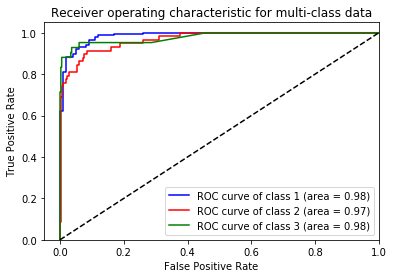

In [63]:
params = {'n_estimators': 1000,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .15}

# Binarize the output
y = label_binarize(y, classes=[1, 2, 3])
n_classes = 3

#X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

classifier = OneVsRestClassifier(ensemble.GradientBoostingClassifier(**params,random_state=0))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.savefig('ROC_GradTree.png')
plt.show()

## Data Scaling

In [296]:
y = df_cardio['NSP']
X = df_cardio.drop(['NSP','Tendency','Nzeros','Nmax','DS','DL'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

params = {'n_estimators': 1000,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .2}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train_clf = clf.predict(X_train)
predict_test_clf = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train_clf, margins=True)
table_test = pd.crosstab(y_test, predict_test_clf, margins=True)

y_pred_clf = clf.predict(X_test)
print('Accuracy of gradient boosted random forest on test set: {:.2f}\n'.format(clf.score(X_test, y_test)))

print(cross_val_score(clf, X_test, y_test, cv=10).mean())

Accuracy of gradient boosted random forest on test set: 0.94

0.9320985603543741


In [297]:
print(np.unique(y_pred_clf))

[1. 2. 3.]


In [298]:
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

         1.0       0.97      0.96      0.97       339
         2.0       0.72      0.81      0.76        48
         3.0       0.97      0.85      0.90        39

    accuracy                           0.94       426
   macro avg       0.89      0.87      0.88       426
weighted avg       0.94      0.94      0.94       426



In [299]:
# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train_clf, margins=True)
table_test = pd.crosstab(y_test, predict_test_clf, margins=True)

train_tI_errors = ((1-(table_train.loc[1.0,1.0]/table_train.loc['All',1.0]))
                   +(1-(table_train.loc[2.0,2.0]/table_train.loc['All',2.0]))
                   +(1-(table_train.loc[3.0,3.0]/table_train.loc['All',3.0])))/3 

train_tII_errors = ((1-(table_train.loc[1.0,1.0]/table_train.loc[1.0,'All']))
                   +(1-(table_train.loc[2.0,2.0]/table_train.loc[2.0,'All']))
                   +(1-(table_train.loc[3.0,3.0]/table_train.loc[3.0,'All'])))/3 

test_tI_errors = ((1-(table_test.loc[1.0,1.0]/table_test.loc['All',1.0]))
                   +(1-(table_test.loc[2.0,2.0]/table_test.loc['All',2.0]))
                   +(1-(table_test.loc[3.0,3.0]/table_test.loc['All',3.0])))/3 

test_tII_errors = ((1-(table_test.loc[1.0,1.0]/table_test.loc[1.0,'All']))
                   +(1-(table_test.loc[2.0,2.0]/table_test.loc[2.0,'All']))
                   +(1-(table_test.loc[3.0,3.0]/table_test.loc[3.0,'All'])))/3 
print((
    'Training set accuracy:\n'
    'AVG Percent Type I errors: {}\n'
    'AVG Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'AVG Percent Type I errors: {}\n'
    'AVG Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
AVG Percent Type I errors: 0.0026773761713520714
AVG Percent Type II errors: 0.0005065856129686056

Test set accuracy:
AVG Percent Type I errors: 0.11324464039396169
AVG Percent Type II errors: 0.12558146131154982


In [300]:
print((
    'Accuracy Differentials:\n'
    'Type I error difference: {}\n\n'
    'Type II error difference: {}\n'
).format(test_tI_errors - train_tI_errors, test_tII_errors - train_tII_errors))

Accuracy Differentials:
Type I error difference: 0.11056726422260962

Type II error difference: 0.12507487569858122



## Upsampling the training data

In [303]:
# Create training and test sets.
offset = int(X.shape[0] * 0.8)

# Put 90% of the data in the training set.
df_train = df_cardio[:offset]

# And put 10% in the test set.
df_test = df_cardio[offset:]

In [304]:
# Separate majority and minority classes
df_majority = df_train[df_train.NSP==1]
df_minority_two = df_train[df_train.NSP==2]
df_minority_three = df_train[df_train.NSP==3]
 
# Upsample minority class
df_minority_two_upsampled = resample(df_minority_two, 
                                 replace=True,     # sample with replacement
                                 n_samples=1315,    # to match majority class
                                 random_state=123) # reproducible results

df_minority_three_upsampled = resample(df_minority_three, 
                                 replace=True,     # sample with replacement
                                 n_samples=1315,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_two_upsampled,df_minority_three_upsampled])
 
# Display new class counts
df_upsampled.NSP.value_counts()

3.0    1315
2.0    1315
1.0    1315
Name: NSP, dtype: int64

In [306]:
y = df_upsampled['NSP']
X = df_upsampled.drop(['NSP','Tendency','Nzeros','Nmax','DS','DL'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465) 
                   
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 465) 
 
params = {'n_estimators': 1000,
          'max_depth': 6,
          'loss': 'deviance',
          'learning_rate': .2}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train_sub, y_train_sub)

predict_train_clf = clf.predict(X_train_sub)
predict_test_clf = clf.predict(X_test_sub)

# Accuracy tables.
table_train = pd.crosstab(y_train_sub, predict_train_clf, margins=True)
table_test = pd.crosstab(y_test_sub, predict_test_clf, margins=True)

y_pred_clf = clf.predict(X_test_sub)
print('Accuracy of gradient boosted random forest on test set: {:.2f}\n'.format(clf.score(X_test_sub, y_test_sub)))

print(cross_val_score(clf, X_test_sub, y_test_sub, cv=10).mean())


Accuracy of gradient boosted random forest on test set: 0.99

0.9302989237465044


In [307]:
print(np.unique(y_pred_clf))

[1. 2. 3.]


In [309]:
print(classification_report(y_test_sub, y_pred_clf))

              precision    recall  f1-score   support

         1.0       1.00      0.98      0.99       211
         2.0       0.98      0.99      0.99       212
         3.0       1.00      1.00      1.00       209

    accuracy                           0.99       632
   macro avg       0.99      0.99      0.99       632
weighted avg       0.99      0.99      0.99       632



In [311]:
# Accuracy tables.
table_train = pd.crosstab(y_train_sub, predict_train_clf, margins=True)
table_test = pd.crosstab(y_test_sub, predict_test_clf, margins=True)

train_tI_errors = ((1-(table_train.loc[1.0,1.0]/table_train.loc['All',1.0]))
                   +(1-(table_train.loc[2.0,2.0]/table_train.loc['All',2.0]))
                   +(1-(table_train.loc[3.0,3.0]/table_train.loc['All',3.0])))/3 

train_tII_errors = ((1-(table_train.loc[1.0,1.0]/table_train.loc[1.0,'All']))
                   +(1-(table_train.loc[2.0,2.0]/table_train.loc[2.0,'All']))
                   +(1-(table_train.loc[3.0,3.0]/table_train.loc[3.0,'All'])))/3 

test_tI_errors = ((1-(table_test.loc[1.0,1.0]/table_test.loc['All',1.0]))
                   +(1-(table_test.loc[2.0,2.0]/table_test.loc['All',2.0]))
                   +(1-(table_test.loc[3.0,3.0]/table_test.loc['All',3.0])))/3 

test_tII_errors = ((1-(table_test.loc[1.0,1.0]/table_test.loc[1.0,'All']))
                   +(1-(table_test.loc[2.0,2.0]/table_test.loc[2.0,'All']))
                   +(1-(table_test.loc[3.0,3.0]/table_test.loc[3.0,'All'])))/3 
print((
    'Training set accuracy:\n'
    'AVG Percent Type I errors: {}\n'
    'AVG Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'AVG Percent Type I errors: {}\n'
    'AVG Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
AVG Percent Type I errors: 0.0004050222762251865
AVG Percent Type II errors: 0.00039215686274511147

Test set accuracy:
AVG Percent Type I errors: 0.009420395284881256
AVG Percent Type II errors: 0.009463769411904965


In [312]:
print((
    'Accuracy Differentials:\n'
    'Type I error difference: {}\n\n'
    'Type II error difference: {}\n'
).format(test_tI_errors - train_tI_errors, test_tII_errors - train_tII_errors))

Accuracy Differentials:
Type I error difference: 0.009015373008656069

Type II error difference: 0.009071612549159854

